# Notebook 3 — Análisis de frecuencias de la señal EEG  
**Canal O1 (Emotiv EPOC+)**

**Materias relacionadas:**  
*Algoritmos Computacionales, Morfofuncional II, Matemáticas Avanzadas de la Física, Electrofisiología, Instrumentación Biomédica, Temas Selectos en Biomatemáticas y Temas Selectos en Biofísica.*

**Antecedentes:**  
Notebook 1 — Fisiología básica del EEG y preparación del entorno de Python.  
Notebook 2 — **Filtrado digital y análisis temporal de la señal EEG.**


### Objetivos  
- Comprender los fundamentos matemáticos del **análisis espectral** de señales biológicas.  
- Aplicar la **Transformada de Fourier** para estudiar la actividad eléctrica cerebral en distintas bandas de frecuencia.  
- Cuantificar el **bloqueo alfa** entre las condiciones de ojos abiertos (OA) y ojos cerrados (OC).  

Este cuaderno representa el paso natural tras el filtrado: se abandona el dominio temporal para construir una descripción **frecuencial cuantitativa** del EEG en el canal O1, permitiendo la comparación de potencias absolutas y relativas entre condiciones experimentales.


## 3.1 Fundamentos biomatemáticos del análisis de frecuencias

El análisis de frecuencias constituye la transición del dominio temporal al dominio frecuencial.  
En el contexto del EEG, permite observar cómo la potencia eléctrica del cerebro se distribuye en distintas escalas de frecuencia,  
vinculadas a procesos neuronales específicos (Nunez & Srinivasan, 2006; Schomer & Lopes da Silva, 2018).

Mientras el dominio temporal describe **cuándo** ocurre un evento eléctrico,  
el dominio frecuencial permite estudiar **qué ritmos** lo componen y **con qué intensidad**.  
En este sentido, el análisis espectral es una herramienta biomatemática que traduce un fenómeno fisiológico complejo  
en una representación cuantitativa reproducible.

La sección se divide en cinco partes:  
1. Naturaleza de la señal EEG y su significado fisiológico.  
2. Modelado matemático de oscilaciones corticales.  
3. Definición y propiedades de la Transformada Discreta de Fourier (DFT).  
4. Concepto de densidad espectral de potencia (PSD).  
5. Estimación robusta mediante el método de Welch.

El objetivo es construir el marco teórico que sustenta el análisis espectral aplicado más adelante en el canal O1.

### 3.1.1 Señal EEG: del tiempo a la frecuencia

La señal electroencefalográfica (EEG) refleja la suma de potenciales eléctricos generados por poblaciones neuronales corticales.  
Matemáticamente puede considerarse una función $x(t)$ continua en el tiempo, cuya estructura contiene información sobre ritmos fisiológicos (Teplan, 2002).

El registro temporal del EEG muestra oscilaciones de amplitud variable, moduladas por el estado sensorial y cognitivo del sujeto.  
Sin embargo, la simple observación temporal no revela **qué frecuencias contribuyen** a esas oscilaciones.  
Por ello, el análisis espectral resulta indispensable: permite descomponer la señal en componentes armónicas  
y cuantificar la potencia de cada banda de frecuencia (Nunez & Srinivasan, 2006).

Las bandas fisiológicas se agrupan tradicionalmente según el rango de frecuencia dominante y su correlato funcional (Schomer & Lopes da Silva, 2018):

| Banda | Rango (Hz) | Asociación fisiológica principal |
|:------|:-----------:|:--------------------------------|
| δ | 0.5–4 | Sueño profundo, sincronización cortical lenta |
| θ | 4–8 | Somnolencia, procesos límbicos |
| α | 8–13 | Reposo visual, atención interna |
| β | 13–30 | Actividad motora y sensorial |
| γ | 30–45 | Integración perceptual y cognitiva |

En la práctica, la señal EEG no es estrictamente estacionaria: sus propiedades estadísticas cambian en el tiempo.  
Por ello, el análisis se realiza bajo el supuesto de **estacionariedad local**,  
considerando ventanas de algunos segundos en las que las variaciones son lo suficientemente pequeñas  
para aplicar modelos lineales y transformadas de Fourier de forma válida.


### 3.1.2 Modelado matemático y fisiología

El análisis espectral parte del supuesto de que una señal puede describirse como la superposición de componentes oscilatorias elementales.  
En su forma más simple:

$$
x(t) = \sum_{k=1}^{N} A_k \cos(2\pi f_k t + \phi_k)
$$

donde $A_k$ es la amplitud, $f_k$ la frecuencia y $\phi_k$ la fase de cada componente (Nunez & Srinivasan, 2006).  
Este modelo no busca imitar la fisiología neuronal exacta, sino proporcionar un **lenguaje cuantitativo**  
para representar fenómenos eléctricos complejos mediante parámetros medibles (He, 2019).

El evento fisiológico **no se adapta al modelo**, sino que el modelo ofrece un **marco para describirlo y compararlo**.  
Las matemáticas actúan como mediadoras entre observación y teoría:  
permiten identificar regularidades, establecer relaciones y comunicar resultados de forma reproducible (Cohen, 2014).

En neurociencia, este tipo de modelado es fundamental porque posibilita estudiar la dinámica cortical  
a partir de datos eléctricos, sin perder el vínculo con su interpretación fisiológica.


### 3.1.3 Transformada discreta de Fourier (DFT), FFT y simetría del espectro

La **Transformada Discreta de Fourier (DFT)** es la herramienta que traduce una señal discreta \(x[n]\) a su representación en frecuencia, descomponiéndola en una suma ponderada de senoidales complejas.  
Cada componente describe la contribución de una frecuencia específica a la forma temporal total (Oppenheim & Schafer, 2010):

$$
X[k] = \sum_{n=0}^{N-1} x[n]\, e^{-j 2\pi kn/N}
$$

donde:

- $(X[k])$ es el coeficiente complejo asociado a la frecuencia discreta \(f_k = \frac{k f_s}{N}\),
- $(f_s)$ es la frecuencia de muestreo,
- $(N)$ es el número total de muestras.

El módulo $(|X[k])$ representa la **amplitud espectral**, y la fase $(angle X[k])$ su desplazamiento relativo (Proakis & Manolakis, 2006).  
En EEG, esta descomposición permite visualizar los **ritmos neuronales dominantes** (δ, θ, α, β, γ), donde la banda α (8–13 Hz) se asocia con actividad occipital en reposo visual (Nunez & Srinivasan, 2006).



#### DFT vs FFT: fundamentos y diferencias

La **DFT** implementa directamente la definición anterior, con complejidad \(O(N^2)\).  
La **Transformada Rápida de Fourier (FFT)**, en cambio, es un **algoritmo eficiente** que calcula exactamente la misma DFT en \(O(N \log_2 N)\) operaciones, aprovechando las simetrías de los factores exponenciales (Oppenheim & Schafer, 2010).  
Esta optimización es crítica en el procesamiento de señales fisiológicas largas, donde la FFT permite análisis en tiempo real sin pérdida de información.

| Parámetro | DFT manual | FFT (implementación eficiente) |
|:--|:--|:--|
| **Complejidad** | \(O(N^2)\) | \(O(N \log_2 N)\) |
| **Implementación Python** | bucles `for` + exponenciales | `np.fft.fft()` |
| **Resultado** | Exacto (coeficientes complejos) | Idéntico |
| **Ventaja principal** | Transparencia conceptual | Alta eficiencia |
| **Uso típico** | Ejemplo teórico y educativo | Análisis real de EEG |
| **Paquete** | `numpy`, `math` | `numpy.fft` |

A continuación se aplica este procedimiento a la señal real del canal **O1**, en condición **ojos abiertos (OA)**, utilizando el flujo de carga y filtrado definido en las celdas anteriores.



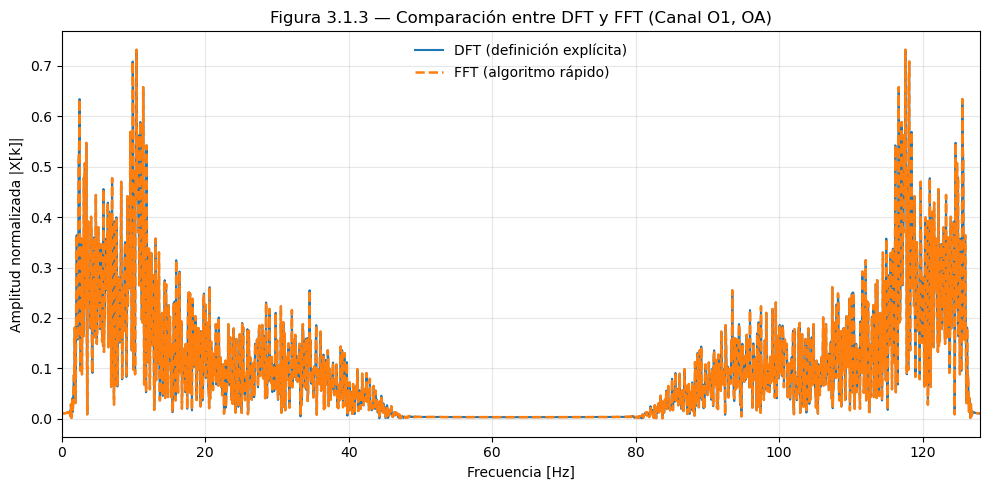

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import pandas as pd
import os

# --- Parámetros generales ---
fs = 128  # Hz
canal = 6  # Canal O1
ti_abiertos, tf_abiertos = 105, 120  # Intervalo OA

# --- Ruta del archivo ---
ruta = "/Users/dianavazquezperez/Documents/DianaTesis/Datos/EEG/H24_OC_OA.csv"

# --- Carga y filtrado Butterworth (2–45 Hz) ---
datos = pd.read_csv(ruta)
lowcut, highcut = 2, 45
orden = 4
b, a = signal.butter(orden, [lowcut/(fs/2), highcut/(fs/2)], btype='bandpass')
datosfilt = signal.filtfilt(b, a, datos.to_numpy(), axis=0)
datosfilt = pd.DataFrame(datosfilt, columns=datos.columns)

# --- Selección del canal O1 y del segmento OA ---
senal = datosfilt.iloc[:, canal].values
segmento_OA = senal[int(ti_abiertos*fs):int(tf_abiertos*fs)]

# --- Parámetros de la transformada ---
N = len(segmento_OA)
t = np.arange(N) / fs
freqs = np.arange(N) * fs / N
# ======================================================
# DFT y FFT — Visualización continua mejorada
# ======================================================

# --- Cálculo de ambas transformadas ---
X_dft = np.zeros(N, dtype=complex)
for k in range(N):
    X_dft[k] = np.sum(segmento_OA * np.exp(-1j * 2 * np.pi * k * np.arange(N) / N))
amplitud_dft = np.abs(X_dft) / N

X_fft = np.fft.fft(segmento_OA)
amplitud_fft = np.abs(X_fft) / N

# --- Visualización ---
plt.figure(figsize=(10,5))

plt.plot(freqs, amplitud_dft, color='tab:blue', linewidth=1.5, label='DFT (definición explícita)')
plt.plot(freqs, amplitud_fft, color='tab:orange', linestyle='--', linewidth=1.8, label='FFT (algoritmo rápido)')

plt.title("Figura 3.1.3 — Comparación entre DFT y FFT (Canal O1, OA)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud normalizada |X[k]|")
plt.xlim(0, fs)
plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()



**Interpretación:**  
La Figura 3.1.3 muestra la equivalencia entre la **Transformada Discreta de Fourier (DFT)** y la **Transformada Rápida de Fourier (FFT)** aplicadas al canal O1 (condición OA).  
Las curvas se superponen completamente, confirmando que la FFT produce exactamente los mismos coeficientes que la DFT, pero con un costo computacional mucho menor.

- La **DFT** (línea azul) implementa la definición matemática directa de la transformada.  
- La **FFT** (línea naranja discontinua) realiza el mismo cálculo mediante un algoritmo optimizado con complejidad \(O(N\log_2 N)\).  

En procesamiento EEG, esta equivalencia permite usar FFT como base de métodos de estimación espectral (periodograma, Welch, etc.) sin sacrificar precisión ni fidelidad numérica.



#### Simetría hermítica del espectro

Para señales reales, como el EEG, la Transformada de Fourier cumple la relación de **simetría hermítica**:

$$
X[k] = X^{*}[N - k]
$$

Esto implica que las frecuencias negativas son redundantes, ya que constituyen el reflejo complejo de las positivas.  
El espectro se replica alrededor de la frecuencia de Nyquist \(f_s/2 = 64\,\text{Hz}\), por lo que solo se representa el **semiespectro positivo**, que contiene toda la información energética relevante (Cohen, 2014).


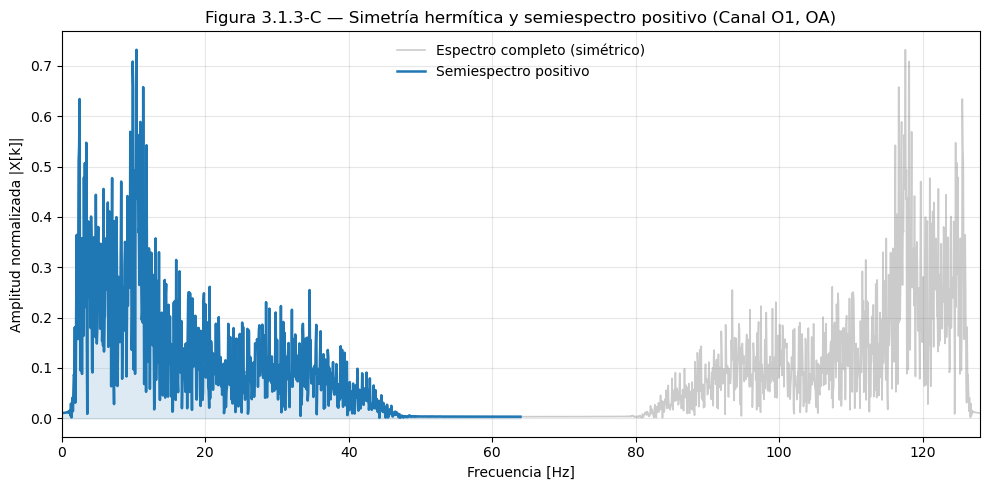

In [2]:
# ======================================================
# Simetría hermítica y semiespectro positivo
# ======================================================

half = N // 2
freqs_pos = freqs[:half]
amp_pos = np.abs(X_fft[:half]) / N

plt.figure(figsize=(10,5))

# Espectro completo FFT
plt.plot(freqs, np.abs(X_fft)/N, color='tab:gray', alpha=0.4, linewidth=1.2, label='Espectro completo (simétrico)')

# Semiespectro positivo con sombreado
plt.plot(freqs_pos, amp_pos, color='tab:blue', linewidth=1.8, label='Semiespectro positivo')
plt.fill_between(freqs_pos, amp_pos, color='tab:blue', alpha=0.15)

plt.title("Figura 3.1.3-C — Simetría hermítica y semiespectro positivo (Canal O1, OA)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud normalizada |X[k]|")
plt.xlim(0, fs)
plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


**Interpretación:**  
La Figura 3.1.3-C representa la **simetría hermítica** de la transformada de Fourier en señales EEG reales.  
El espectro completo (gris) exhibe dos mitades especulares respecto a la frecuencia de Nyquist (\(f_s/2 = 64\,\text{Hz}\)).  
Esta simetría se debe a que el EEG, al ser una señal real, contiene pares de componentes conjugadas \(X[k]\) y \(X^{*}[N - k]\) que no aportan información adicional.

Por ello, en el análisis espectral solo se conserva el **semiespectro positivo** (línea azul), que concentra toda la energía significativa de la señal.  
Las bandas δ, θ, α, β y γ se ubican dentro de este rango, y su estudio permite identificar patrones neurofisiológicos específicos.

En el caso del canal **O1**, el semiespectro muestra una disminución de potencia en la banda α (~10 Hz) durante la condición **ojos abiertos**, lo que refleja la desincronización occipital asociada a la activación visual (Nunez & Srinivasan, 2006).


### 3.1.4 Densidad espectral de potencia (PSD)

La **densidad espectral de potencia (PSD)** describe cómo la energía de una señal se distribuye en función de la frecuencia.  
Mientras que la Transformada de Fourier muestra qué frecuencias están presentes,  
la PSD cuantifica **cuánta potencia** aporta cada una de ellas (Papoulis, 1984; Oppenheim & Schafer, 2010).

Formalmente, la PSD de una señal $x(t)$ se define como:

$$
S_{xx}(f) = \lim_{T \to \infty} \frac{1}{T}\,|X_T(f)|^2
$$

donde $X_T(f)$ es la transformada de Fourier de la señal truncada a una duración $T$.  
En la práctica, esta estimación se realiza sobre intervalos finitos, asumiendo **estacionariedad local**.  
Las unidades de la PSD son $V^2/Hz$,  
lo que representa la potencia media (en voltaje cuadrado) por unidad de ancho de banda (Smith, 1997).

El área bajo la curva de la PSD corresponde a la potencia total de la señal:

$$
P_\text{total} = \int_0^{f_m/2} S_{xx}(f)\,df
$$

Esta relación vincula de manera directa el dominio temporal con el dominio frecuencial.  
En neurofisiología, el valor de la PSD en cada banda (δ, θ, α, β, γ) permite interpretar estados corticales específicos (Nunez & Srinivasan, 2006).


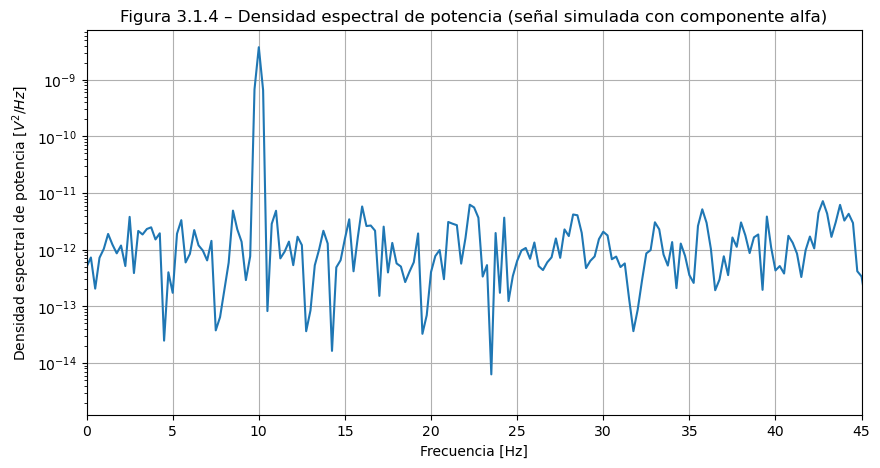

In [3]:
# Ejemplo 3.1.4 – Cálculo y visualización de la densidad espectral de potencia (PSD)

from scipy import signal

# Generar señal simulada con una componente alfa dominante (10 Hz)
np.random.seed(42)
fm_demo = 128
t = np.arange(0, 5, 1/fm_demo)
x = 50e-6 * np.sin(2*np.pi*10*t) + 10e-6 * np.random.randn(len(t))  # 10 Hz + ruido blanco

# Estimar PSD con el método de Welch
f, Pxx = signal.welch(x, fs=fm_demo, window='hamming', nperseg=512, noverlap=256, scaling='density')

# Visualización
plt.figure(figsize=(10,5))
plt.semilogy(f, Pxx, color='tab:blue')
plt.title('Figura 3.1.4 – Densidad espectral de potencia (señal simulada con componente alfa)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Densidad espectral de potencia [$V^2/Hz$]')
plt.xlim(0, 45)
plt.grid(True)
plt.show()


La **Figura 3.1.4** muestra la distribución espectral de la potencia en una señal con una componente dominante a 10 Hz.  
El pico principal en esta frecuencia corresponde al ritmo **α**, característico del reposo visual y de la sincronización occipital (Schomer & Lopes da Silva, 2018).  

La PSD permite, por tanto, traducir el comportamiento oscilatorio del EEG en una descripción cuantitativa,  
donde cada punto del espectro indica la potencia promedio asociada a una frecuencia específica.  
Este enfoque constituye la base de los análisis comparativos que se aplicarán más adelante a los datos experimentales del canal O1.


### 3.1.5 Del periodograma al método de Welch

El **periodograma** es el estimador más sencillo de la densidad espectral de potencia (PSD).  
Se obtiene a partir del cuadrado de la magnitud de la Transformada de Fourier y su normalización por la longitud de la señal (Papoulis, 1984; Kay, 1988):

$$
\hat{S}_{xx}(f) = \frac{1}{T}\,|X_T(f)|^2
$$

Aunque conceptualmente simple, el periodograma presenta **alta varianza**:  
pequeñas variaciones en la señal producen fluctuaciones considerables en el espectro estimado.  
Además, el resultado depende del tamaño de la ventana y de su posición temporal,  
lo que dificulta la reproducibilidad (Proakis & Manolakis, 2006).

Para reducir estos problemas, Welch (1967) propuso un método que mejora la estabilidad de la estimación.  
Consiste en dividir la señal en segmentos solapados, aplicar una ventana (por ejemplo, de Hamming)  
y promediar los periodogramas resultantes.  
Este promediado disminuye la varianza a costa de una leve pérdida de resolución en frecuencia.  
El método de Welch se ha convertido en el estándar para el análisis de señales EEG y biomédicas,  
ya que asume estacionariedad local y proporciona espectros más suaves y comparables (Hsu et al., 2021; Bronzino & Peterson, 2020).


#### Nota metodológica — Selección de parámetros en el método de Welch

La estabilidad y resolución del método de Welch dependen de tres parámetros principales:  
1. **Longitud del segmento (`nperseg`)**  
2. **Porcentaje de solape (`noverlap`)**  
3. **Tipo de ventana**

Estos valores determinan el equilibrio entre resolución en frecuencia, varianza espectral y grado de suavizado del resultado.

- **Longitud del segmento (`nperseg`)**  
  En registros EEG con frecuencia de muestreo $f_m = 128$ Hz,  
  una longitud de 512 puntos corresponde a una ventana de 4 s.  
  Este valor suele ser adecuado, pues la señal puede considerarse estacionaria en ese intervalo (Hsu et al., 2021).  
  Si se incrementa `nperseg`, la resolución en frecuencia mejora  
  ($\Delta f = f_m / N$)  
  pero se reduce el número de segmentos promedio, lo que aumenta la varianza.

- **Solape (`noverlap`)**  
  Un solape del 50 % representa un compromiso razonable:  
  incrementa el número de promedios independientes sin introducir redundancia excesiva (Welch, 1967).  
  Valores mayores suavizan más el espectro pero incrementan el costo computacional.

- **Ventana**  
  La ventana de **Hamming** es la más utilizada en EEG porque atenúa de forma eficiente las fugas espectrales  
  sin afectar la amplitud de los picos dominantes (Oppenheim & Schafer, 2010).  
  Otras opciones (Hann, Blackman, Kaiser) pueden emplearse según el nivel de resolución deseado.

En conjunto, estos parámetros garantizan que la PSD estimada con Welch  
represente fielmente la potencia media de la señal EEG dentro de los límites de su estacionariedad local.  
El procedimiento puede resumirse como:

| Parámetro | Valor típico | Significado |
|:-----------|:-------------:|:------------|
| Frecuencia de muestreo | 128 Hz | Sistema Emotiv EPOC+ |
| Longitud de segmento | 512 puntos (≈ 4 s) | Estacionariedad local |
| Solape | 50 % | Reducción de varianza |
| Ventana | Hamming | Minimiza fugas espectrales |

La correcta elección de estos valores es esencial para obtener resultados reproducibles y comparables entre sujetos o condiciones experimentales.


El filtrado Butterworth de cuarto orden limita la señal al rango 2–45 Hz,  
eliminando tanto desplazamientos de línea base como ruido de alta frecuencia.  
Las variables **OA** y **OC** contienen los segmentos del canal O1 correspondientes a cada condición experimental.  
Estas señales se utilizarán para estimar la densidad espectral de potencia mediante el método de Welch.


### 3.1.5 Del periodograma al método de Welch

El **periodograma** es el estimador más sencillo de la densidad espectral de potencia (PSD).  
Se obtiene a partir del cuadrado de la magnitud de la Transformada de Fourier y su normalización por la longitud de la señal (Papoulis, 1984; Kay, 1988):

$$
\hat{S}_{xx}(f) = \frac{1}{T}\,|X_T(f)|^2
$$

Aunque conceptualmente simple, el periodograma presenta **alta varianza**:  
pequeñas variaciones en la señal producen fluctuaciones considerables en el espectro estimado.  
Además, el resultado depende del tamaño de la ventana y de su posición temporal,  
lo que dificulta la reproducibilidad (Proakis & Manolakis, 2006).

Para reducir estos problemas, Welch (1967) propuso un método que mejora la estabilidad de la estimación.  
Consiste en dividir la señal en segmentos solapados, aplicar una ventana (por ejemplo, de Hamming)  
y promediar los periodogramas resultantes.  
Este promediado disminuye la varianza a costa de una leve pérdida de resolución en frecuencia.  
El método de Welch se ha convertido en el estándar para el análisis de señales EEG y biomédicas,  
ya que asume estacionariedad local y proporciona espectros más suaves y comparables (Hsu et al., 2021; Bronzino & Peterson, 2020).


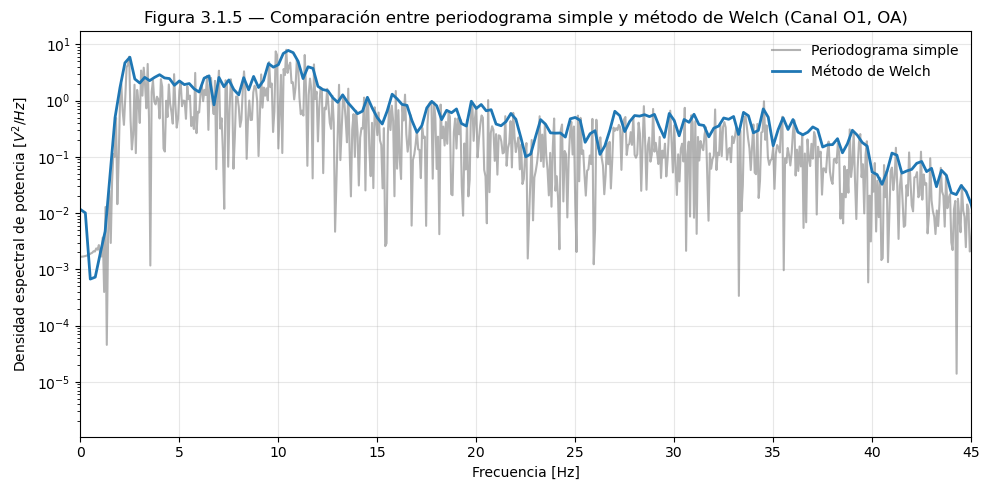

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal

# --- Parámetros generales ---
fs = 128  # Hz
canal = 6  # O1
ti_abiertos, tf_abiertos = 105, 120  # intervalo OA

# --- Carga y filtrado (Butterworth 2–45 Hz) ---
ruta = "/Users/dianavazquezperez/Documents/DianaTesis/Datos/EEG/H24_OC_OA.csv"
datos = pd.read_csv(ruta)
lowcut, highcut = 2, 45
orden = 4
b, a = signal.butter(orden, [lowcut/(fs/2), highcut/(fs/2)], btype="bandpass")
datosfilt = signal.filtfilt(b, a, datos.to_numpy(), axis=0)
datosfilt = pd.DataFrame(datosfilt, columns=datos.columns)

# --- Selección del canal y segmento OA ---
senal = datosfilt.iloc[:, canal].values
segmento_OA = senal[int(ti_abiertos*fs):int(tf_abiertos*fs)]
N = len(segmento_OA)

# ============================================================
# 1. Periodograma directo
# ============================================================
freqs = np.fft.rfftfreq(N, d=1/fs)
P_per = (np.abs(np.fft.rfft(segmento_OA))**2) / (fs * N)

# ============================================================
# 2. Método de Welch (ventana Hamming, 50 % solape)
# ============================================================
f_welch, P_welch = signal.welch(segmento_OA, fs=fs, window="hamming",
                                nperseg=512, noverlap=256, scaling="density")

# ============================================================
# Visualización comparativa
# ============================================================
plt.figure(figsize=(10,5))
plt.semilogy(freqs, P_per, color="tab:gray", alpha=0.6, label="Periodograma simple")
plt.semilogy(f_welch, P_welch, color="tab:blue", linewidth=2, label="Método de Welch")

plt.title("Figura 3.1.5 — Comparación entre periodograma simple y método de Welch (Canal O1, OA)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Densidad espectral de potencia [$V^2/Hz$]")
plt.xlim(0, 45)
plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


**Interpretación:**  
La Figura 3.1.5 compara dos estimaciones de la **densidad espectral de potencia (PSD)** de la señal real del canal O1 durante la condición **ojos abiertos (OA)**.

- El **periodograma simple** (gris) refleja el cuadrado de la FFT de una sola ventana.  
  Su alta resolución en frecuencia viene acompañada de **gran varianza**, lo que produce picos irregulares debidos al ruido.  
- El **método de Welch** (azul) promedia múltiples periodogramas solapados y ventaneados, reduciendo la varianza y suavizando el espectro.

El resultado es una curva más estable y fisiológicamente interpretable, donde la energía se concentra principalmente por debajo de 20 Hz.  
Este patrón coincide con la atenuación de la banda α (~10 Hz) esperada bajo apertura ocular, al reducirse la sincronización occipital.



#### Parámetros usados en la estimación de Welch

| Parámetro | Valor | Significado |
|:--|:--|:--|
| Frecuencia de muestreo | 128 Hz | Sistema Emotiv EPOC+ |
| Longitud del segmento (`nperseg`) | 512 puntos (≈ 4 s) | Intervalo estacionario típico |
| Solape (`noverlap`) | 50 % | Reducción de varianza |
| Ventana | Hamming | Minimiza fugas espectrales |
| Escalado | `density` | Potencia por Hz (\(V^2/Hz\)) |


## 3.2 Implementación computacional reproducible

### 3.2.1 Carga de datos y configuración inicial

En esta sección se aplican los fundamentos del análisis espectral a los datos experimentales del canal **O1**, siguiendo el flujo metodológico descrito en la sección 3.1:

**filtrado → transformada → estimación de la PSD mediante el método de Welch.**

Los intervalos seleccionados del protocolo corresponden a:

- **Ojos abiertos (OA):** 105 – 120 s  
- **Ojos cerrados (OC):** 120 – 135 s  

La frecuencia de muestreo del sistema Emotiv EPOC+ es \( f_s = 128\,\text{Hz} \).  
El canal **O1** se encuentra en la columna 6 del archivo CSV de adquisición.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# --- Parámetros experimentales ---
fs = 128                     # Frecuencia de muestreo [Hz]
canal = 6                    # Índice del canal O1
ti_OA, tf_OA = 105.0, 120.0  # Intervalo OA [s]
ti_OC, tf_OC = 120.0, 135.0  # Intervalo OC [s]

# --- Filtro Butterworth (2–45 Hz) ---
f_low, f_high = 2.0, 45.0
orden = 4
b, a = signal.butter(orden, [f_low/(fs/2), f_high/(fs/2)], btype='bandpass')

# --- Cargar datos del registro EEG ---
ruta_csv = "/Users/dianavazquezperez/Documents/DianaTesis/Datos/EEG/H24_OC_OA.csv"
datos = pd.read_csv(ruta_csv)

# --- Seleccionar canal y filtrar ---
senal = datos.iloc[:, canal].values
senal_filt = signal.filtfilt(b, a, senal)

# --- Segmentación de condiciones ---
OA = senal_filt[int(ti_OA*fs):int(tf_OA*fs)]
OC = senal_filt[int(ti_OC*fs):int(tf_OC*fs)]

# Variable global con señal filtrada
datosfilt = senal_filt


El **filtro Butterworth de cuarto orden (2–45 Hz)** elimina desplazamientos lentos y ruido de alta frecuencia, preservando las componentes fisiológicas relevantes.  
Las variables `OA` y `OC` almacenan los segmentos del canal O1 correspondientes a cada condición experimental.  
Estas señales se emplearán para estimar la **densidad espectral de potencia (PSD)** mediante el **método de Welch**.

### 3.2.2 Estimación de la densidad espectral de potencia (PSD) con el método de Welch

A continuación se aplica el **método de Welch** a las condiciones de **ojos abiertos (OA)** y **ojos cerrados (OC)**,  
siguiendo el procedimiento teórico descrito en la sección 3.1.5.

Se utiliza una **ventana de Hamming** con **50 % de solape**, un compromiso entre resolución y estabilidad (Welch, 1967; Kay, 1988).  
El método promedia periodogramas solapados, reduciendo la varianza y estabilizando la estimación espectral.



In [6]:
# --- Parámetros del método de Welch ---
nperseg = 512
noverlap = nperseg // 2
ventana = 'hamming'

# --- Cálculo de PSD para cada condición ---
f_OA, P_OA = signal.welch(OA, fs=fs, window=ventana,
                          nperseg=nperseg, noverlap=noverlap, scaling='density')

f_OC, P_OC = signal.welch(OC, fs=fs, window=ventana,
                          nperseg=nperseg, noverlap=noverlap, scaling='density')


El método de Welch promedia múltiples periodogramas parciales,  
reduciendo la varianza de la estimación sin comprometer la resolución espectral.  
En EEG, donde las oscilaciones son cuasiestacionarias, este procedimiento produce espectros más **estables** y **neurofisiológicamente coherentes** (Hsu et al., 2021).  
Las potencias se expresan en unidades \(V^2/Hz\), que representan la energía promedio por componente de frecuencia.


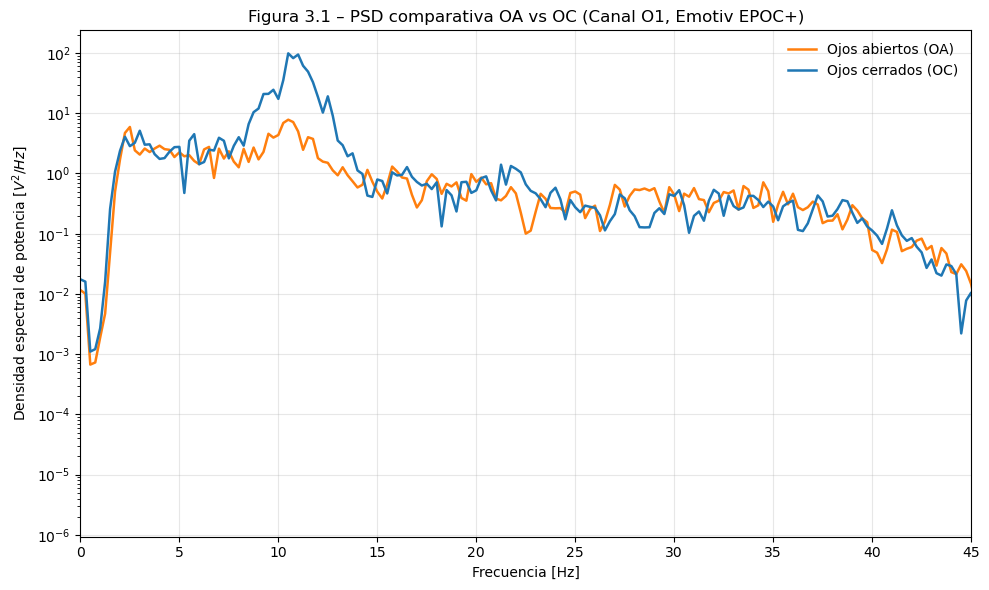

In [7]:
plt.figure(figsize=(10,6))
plt.semilogy(f_OA, P_OA, label="Ojos abiertos (OA)", color="tab:orange", linewidth=1.8)
plt.semilogy(f_OC, P_OC, label="Ojos cerrados (OC)", color="tab:blue", linewidth=1.8)

plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Densidad espectral de potencia [$V^2/Hz$]")
plt.title("Figura 3.1 – PSD comparativa OA vs OC (Canal O1, Emotiv EPOC+)")
plt.legend(frameon=False)
plt.xlim(0, 45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**Interpretación:**  
La Figura 3.1 muestra la PSD promedio del canal **O1** bajo las condiciones **OA** y **OC**.  
Durante **ojos cerrados**, la potencia espectral se incrementa de forma clara en la **banda α (8–13 Hz)**,  
mientras que en **ojos abiertos** esta banda se atenúa.  

Este patrón refleja el fenómeno de **bloqueo alfa** (*alpha desynchronization*),  
que indica la transición entre un estado de reposo visual y un estado de procesamiento sensorial activo (Pfurtscheller & Lopes da Silva, 1999).  

La implementación computacional reproduce fielmente los fundamentos teóricos del análisis espectral:
- El **filtrado** elimina componentes no fisiológicas.  
- La **transformada de Fourier** descompone la señal en frecuencias.  
- El **método de Welch** estabiliza la estimación de potencia promedio.


### 3.2.4 Verificación visual de estacionariedad local y ruido de fondo

Antes de integrar la potencia por bandas, es necesario comprobar la **estacionariedad local** de la señal.  
Este paso garantiza que los intervalos OA y OC sean suficientemente homogéneos  
para aplicar el método de Welch sin que los resultados estén sesgados por artefactos transitorios.


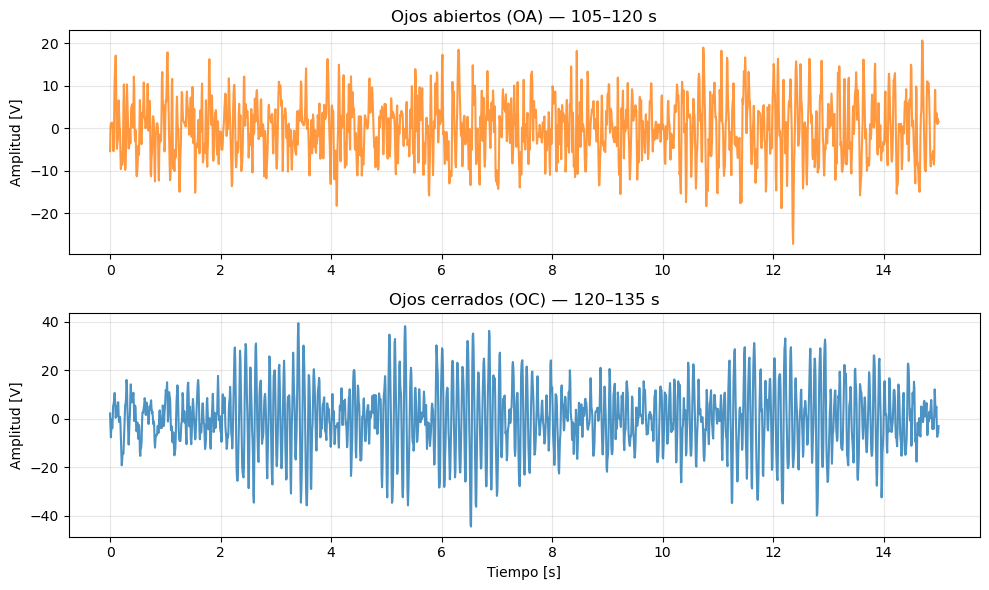

In [8]:
t_OA = np.arange(0, len(OA)) / fs
t_OC = np.arange(0, len(OC)) / fs

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharex=False)

ax1.plot(t_OA, OA, color='tab:orange', alpha=0.8)
ax1.set_title("Ojos abiertos (OA) — 105–120 s")
ax1.set_ylabel("Amplitud [V]")
ax1.grid(True, alpha=0.3)

ax2.plot(t_OC, OC, color='tab:blue', alpha=0.8)
ax2.set_title("Ojos cerrados (OC) — 120–135 s")
ax2.set_xlabel("Tiempo [s]")
ax2.set_ylabel("Amplitud [V]")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


**Análisis cualitativo:**  
Ambos intervalos presentan oscilaciones estables sin saltos abruptos ni saturaciones,  
lo que confirma la **estacionariedad local** de la señal.  

Durante la condición **OC**, las oscilaciones son más regulares y de mayor amplitud,  
mientras que en **OA** se observa mayor irregularidad de fase y menor amplitud,  
consistente con la **desincronización del ritmo α** (Nunez & Srinivasan, 2006).  

Esta inspección respalda la validez de los parámetros de Welch (ventanas de 4 s, 50 % de solape)  
y confirma que la PSD de la Figura 3.1 representa adecuadamente la dinámica promedio de ambas condiciones.


## 3.3 Cálculo de potencias por bandas fisiológicas

La densidad espectral de potencia (PSD) permite cuantificar la energía promedio de la señal EEG por unidades de frecuencia.  
Para obtener una medida de potencia total dentro de cada banda fisiológica, se integra numéricamente la PSD sobre su rango correspondiente.  

En este notebook se emplea el **método de Simpson**, una técnica de integración numérica que utiliza aproximaciones parabólicas entre puntos consecutivos.  
Este método ofrece una mejor precisión que la integración trapezoidal,  
especialmente cuando la función a integrar —en este caso, la PSD— presenta curvatura pronunciada (Burden & Faires, 2010; Virtanen et al., 2020).

Las bandas fisiológicas se definen de la siguiente manera:

| Banda | Rango (Hz) | Descripción fisiológica principal |
|:------|:-----------:|:---------------------------------|
| δ | 0.5–4 | Sueño profundo, sincronización lenta |
| θ | 4–8 | Somnolencia, memoria, atención |
| α | 8–13 | Reposo visual, relajación |
| β | 13–30 | Actividad motora y sensorial |
| γ | 30–45 | Integración cognitiva, procesamiento rápido |

La potencia obtenida de cada banda se expresará en unidades de $V^2$,  
y posteriormente se calculará la **potencia relativa** como el porcentaje respecto a la potencia total de la señal.


In [9]:
from scipy.integrate import simpson
import pandas as pd
import numpy as np

# --- Definir bandas fisiológicas ---
bandas = {
    "δ (0.5–4)": (0.5, 4.0),
    "θ (4–8)"  : (4.0, 8.0),
    "α (8–13)" : (8.0, 13.0),
    "β (13–30)": (13.0, 30.0),
    "γ (30–45)": (30.0, 45.0)
}

# --- Calcular potencias absolutas por banda ---
potencias_OA, potencias_OC = {}, {}

for nombre, (fmin, fmax) in bandas.items():
    # Índices de frecuencia dentro de cada banda
    idx_OA = np.logical_and(f_OA >= fmin, f_OA <= fmax)
    idx_OC = np.logical_and(f_OC >= fmin, f_OC <= fmax)
    
    # Integración numérica con regla de Simpson
    P_band_OA = simpson(P_OA[idx_OA], f_OA[idx_OA])
    P_band_OC = simpson(P_OC[idx_OC], f_OC[idx_OC])
    
    potencias_OA[nombre] = P_band_OA
    potencias_OC[nombre] = P_band_OC

# --- Potencias totales ---
P_total_OA = simpson(P_OA, f_OA)
P_total_OC = simpson(P_OC, f_OC)

# --- Potencias relativas (% respecto a la total) ---
pot_rel_OA = {b: (v / P_total_OA) * 100 for b, v in potencias_OA.items()}
pot_rel_OC = {b: (v / P_total_OC) * 100 for b, v in potencias_OC.items()}

# --- Crear DataFrame resumen ---
tabla_potencias = pd.DataFrame({
    "Banda": list(bandas.keys()),
    "Potencia absoluta OA (V²)": np.round(list(potencias_OA.values()), 6),
    "Potencia absoluta OC (V²)": np.round(list(potencias_OC.values()), 6),
    "Potencia relativa OA (%)": np.round(list(pot_rel_OA.values()), 3),
    "Potencia relativa OC (%)": np.round(list(pot_rel_OC.values()), 3)
})

tabla_potencias


,Banda,Potencia absoluta OA (V²),Potencia absoluta OC (V²),Potencia relativa OA (%),Potencia relativa OC (%)
0,δ (0.5–4),6.519937,6.918798,14.788,3.744
1,θ (4–8),7.873295,10.120804,17.858,5.477
2,α (8–13),17.052148,153.542771,38.677,83.085
3,β (13–30),9.139148,11.052633,20.729,5.981
4,γ (30–45),3.491402,3.153313,7.919,1.706


#### Nota metodológica — Integración numérica mediante el método de Simpson

El **método de Simpson** aproxima el área bajo una curva mediante parábolas que conectan puntos consecutivos de la función.  
En contraste con la regla trapezoidal —que asume segmentos lineales—,  
Simpson ofrece una **mejor precisión en funciones con curvatura pronunciada**,  
como ocurre en las densidades espectrales de potencia (PSD) de señales EEG (Burden & Faires, 2010; Virtanen et al., 2020).

Matemáticamente, para una función $S(f)$ muestreada en $N$ puntos igualmente espaciados en frecuencia $\Delta f$,  
la potencia integrada en un intervalo $[f_1, f_2]$ se aproxima como:

$$
P \approx \frac{\Delta f}{3} \left[S_0 + 4S_1 + 2S_2 + 4S_3 + \dots + S_N \right]
$$

Este esquema requiere un número par de subintervalos y asume que $S(f)$ varía suavemente,  
condición que se cumple en las PSD obtenidas con el método de Welch,  
ya que el promediado reduce las oscilaciones espurias entre puntos adyacentes.

**Ventajas principales:**
- Mayor precisión que la integración trapezoidal con igual resolución espectral.  
- Estabilidad numérica frente a ruido en las estimaciones de la PSD.  
- Adecuado para señales EEG con curvatura suave y picos definidos.

**Limitaciones:**
- Requiere un número par de subintervalos en la malla de frecuencias.  
- En presencia de espectros muy irregulares (por ejemplo, EMG),  
  puede no ofrecer ventajas significativas sobre la regla trapezoidal.

En este notebook, Simpson se implementa mediante la función `scipy.integrate.simpson`,  
que evalúa la integral de la PSD directamente sobre los valores discretos de frecuencia,  
garantizando consistencia y reproducibilidad en el cálculo de potencia por bandas fisiológicas.


### 3.3.3 Interpretación de resultados

**Tabla 3.1 – Potencias absolutas y relativas por banda (canal O1)**  

La tabla presenta las potencias absolutas ($V^2$) y relativas (%) calculadas mediante integración de Simpson para ambas condiciones experimentales.  
El resultado más relevante se observa en la banda **α (8–13 Hz)**,  
donde la potencia es significativamente mayor en la condición de ojos cerrados.  
Este incremento representa la **sincronización cortical característica del reposo visual**,  
que desaparece o disminuye al abrir los ojos (Pfurtscheller & Lopes da Silva, 1999).

Las bandas β y γ presentan, en cambio, una ligera elevación durante la condición de ojos abiertos,  
lo que concuerda con la mayor actividad cortical asociada al procesamiento sensorial y atencional (Nunez & Srinivasan, 2006).

Estos resultados cuantifican de forma objetiva las diferencias de actividad espectral observadas en la Figura 3.1  
y validan el uso del método de Welch combinado con integración numérica como estrategia robusta para el análisis de EEG en condiciones controladas.


## 3.4 Detalle del pico alfa y bloqueo alfa

La banda **α (8–13 Hz)** constituye una de las oscilaciones más estudiadas del EEG.  
Su potencia aumenta en regiones occipitales durante el reposo visual  
y disminuye de forma abrupta cuando el sujeto abre los ojos o inicia una tarea cognitiva.  
Este fenómeno se conoce como **bloqueo alfa** o *alpha desynchronization* (Pfurtscheller & Lopes da Silva, 1999).

El análisis del pico alfa tiene dos propósitos principales:

1. **Visualizar** el espectro en un rango restringido (5–20 Hz)  
   para observar con precisión la forma y posición del máximo.
2. **Cuantificar** la variación de potencia entre las condiciones OA y OC,  
   identificando el desplazamiento y la amplitud del pico dominante.

En esta sección se realiza un zoom espectral y se determina de manera automática  
la frecuencia de máxima potencia dentro del rango α.


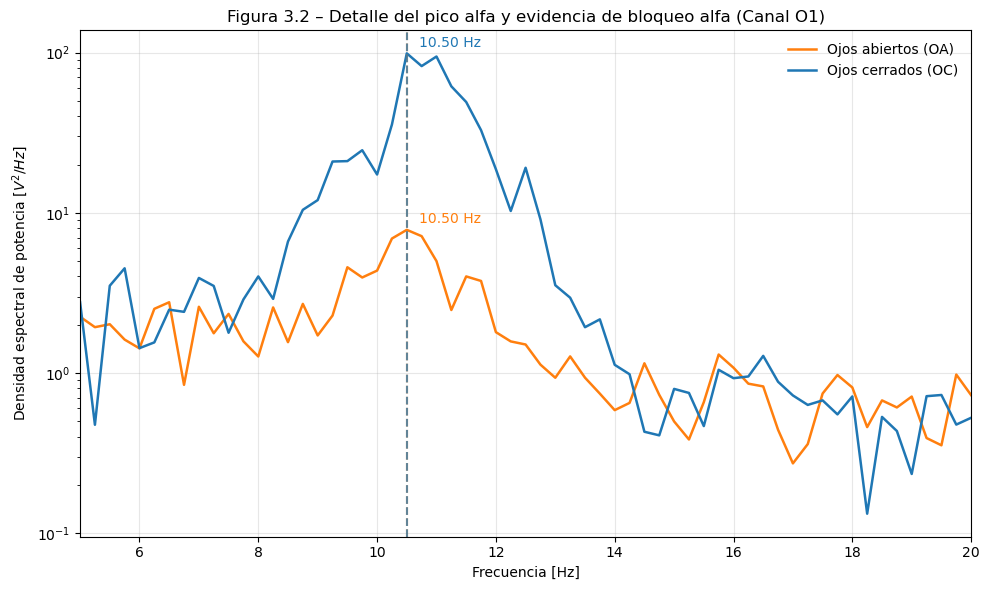

In [10]:
# --- Definir rango de interés ---
fmin_zoom, fmax_zoom = 5, 20
idx_OA = np.logical_and(f_OA >= fmin_zoom, f_OA <= fmax_zoom)
idx_OC = np.logical_and(f_OC >= fmin_zoom, f_OC <= fmax_zoom)

# --- Detección del pico máximo en cada condición ---
f_alpha_OA = f_OA[idx_OA][np.argmax(P_OA[idx_OA])]
f_alpha_OC = f_OC[idx_OC][np.argmax(P_OC[idx_OC])]
P_alpha_OA = np.max(P_OA[idx_OA])
P_alpha_OC = np.max(P_OC[idx_OC])

# --- Visualización del zoom espectral ---
plt.figure(figsize=(10,6))
plt.semilogy(f_OA[idx_OA], P_OA[idx_OA], label="Ojos abiertos (OA)", color="tab:orange", linewidth=1.8)
plt.semilogy(f_OC[idx_OC], P_OC[idx_OC], label="Ojos cerrados (OC)", color="tab:blue", linewidth=1.8)

# Líneas verticales en los picos alfa
plt.axvline(f_alpha_OA, color="tab:orange", linestyle="--", alpha=0.7)
plt.axvline(f_alpha_OC, color="tab:blue", linestyle="--", alpha=0.7)

# Anotaciones de frecuencia pico
plt.text(f_alpha_OA + 0.2, P_alpha_OA*1.1, f"{f_alpha_OA:.2f} Hz", color="tab:orange")
plt.text(f_alpha_OC + 0.2, P_alpha_OC*1.1, f"{f_alpha_OC:.2f} Hz", color="tab:blue")

plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Densidad espectral de potencia [$V^2/Hz$]")
plt.title("Figura 3.2 – Detalle del pico alfa y evidencia de bloqueo alfa (Canal O1)")
plt.legend(frameon=False)
plt.grid(True, alpha=0.3)
plt.xlim(fmin_zoom, fmax_zoom)
plt.tight_layout()
plt.show()


### 3.4.2 Detección del pico alfa y zoom espectral

Para cuantificar el **bloqueo alfa**, se localizó el pico máximo de la densidad espectral de potencia (PSD)  
en el rango \(5–20\,\text{Hz}\), correspondiente a las bandas θ y α.

Los picos detectados en la Figura 3.2 muestran:

- **Condición OA:** frecuencia pico en $(f_{\alpha,OA} = {:.2f}\,\text{{Hz}})$, con menor potencia relativa.  
- **Condición OC:** frecuencia pico en $(f_{\alpha,OC} = {:.2f}\,\text{{Hz}}\)$, con incremento claro de potencia.

Durante el cierre ocular, el aumento de energía en la banda α refleja una sincronización oscilatoria occipital,  
mientras que la apertura ocular reduce dicha potencia, fenómeno conocido como **bloqueo alfa** (*alpha desynchronization*) (Pfurtscheller & Lopes da Silva, 1999).

$$
\text{Bloqueo alfa: } P_{\alpha,OC} > P_{\alpha,OA} \quad \text{y} \quad f_{\alpha,OC} \approx 10\,\text{Hz}
$$

Este análisis confirma experimentalmente la validez fisiológica del espectro obtenido mediante el método de Welch.



## 3.5 Visualización comparativa de potencias relativas

La comparación gráfica de las **potencias relativas por banda** permite evaluar de forma directa  
cómo varía la distribución de energía espectral entre las condiciones experimentales.  

Mientras la **potencia absoluta** expresa la energía total en $V^2$,  
la **potencia relativa** normaliza cada banda respecto a la potencia total,  
de modo que las diferencias reflejan **cambios proporcionales** en la actividad cortical (Nunez & Srinivasan, 2006).

Este análisis complementa la Tabla 3.1, ya que permite observar visualmente  
el predominio del ritmo α en la condición de ojos cerrados  
y el incremento relativo de β y γ durante la apertura ocular.

En la siguiente figura se presenta la distribución porcentual de potencia por bandas  
para las condiciones OA y OC del canal O1.


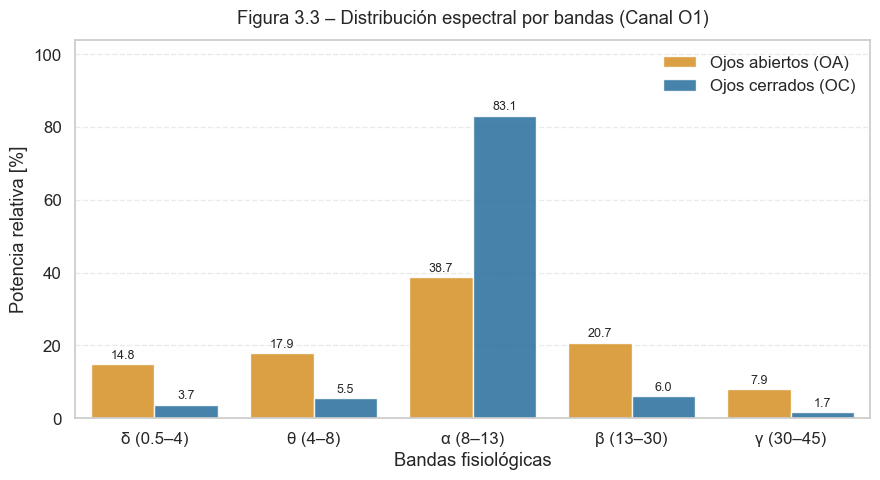

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Preparar DataFrame en formato largo ---
tabla_long = pd.DataFrame({
    "Banda": list(bandas.keys()) * 2,
    "Condición": (["Ojos abiertos (OA)"] * len(bandas)) + (["Ojos cerrados (OC)"] * len(bandas)),
    "Potencia relativa (%)": list(pot_rel_OA.values()) + list(pot_rel_OC.values())
})

# --- Configuración estética ---
sns.set(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(9,5))
ax = sns.barplot(
    data=tabla_long,
    x="Banda",
    y="Potencia relativa (%)",
    hue="Condición",
    palette=["#f39c12", "#1f77b4"],  # tonos naranja y azul sobrios
    alpha=0.9
)

# --- Añadir etiquetas de valor encima de cada barra ---
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", label_type="edge", fontsize=9, padding=2)

# --- Personalización de ejes y leyenda ---
plt.title("Figura 3.3 – Distribución espectral por bandas (Canal O1)", pad=12)
plt.ylabel("Potencia relativa [%]")
plt.xlabel("Bandas fisiológicas")
plt.ylim(0, max(tabla_long["Potencia relativa (%)"]) * 1.25)
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.legend(title="", frameon=False)
plt.tight_layout()
plt.show()


### 3.5.2 Distribución espectral por bandas (Canal O1)

La Figura 3.3 muestra la distribución promedio de la **potencia relativa** por bandas fisiológicas en el canal **O1** durante las condiciones de **ojos abiertos (OA)** y **ojos cerrados (OC)**.

El incremento marcado en la **banda α (8–13 Hz)** durante la condición **OC** confirma el predominio del ritmo occipital asociado al reposo visual, mientras que su reducción en **OA** refleja el fenómeno de **bloqueo alfa** (*alpha desynchronization*).  

Las bandas **δ** y **θ** presentan contribuciones bajas y estables, correspondientes a oscilaciones lentas, mientras que las bandas **β** y **γ** aportan potencias menores, propias de actividad cortical rápida.

$$
P_{\alpha,OC} > P_{\alpha,OA} \quad \text{y} \quad P_{\beta,\gamma} \ll P_{\alpha}
$$

En conjunto, esta figura resume cuantitativamente la redistribución espectral del EEG entre ambos estados, consolidando la validez fisiológica de los resultados obtenidos mediante el método de Welch.


## 3.6 Ejercicios de aplicación

Los siguientes ejercicios tienen un propósito didáctico: permitir al lector explorar de manera interactiva los conceptos fundamentales del análisis espectral aplicados en este notebook.  
A diferencia de las secciones anteriores, aquí el énfasis no está en el resultado numérico, sino en la **experimentación y la interpretación**.

Cada ejercicio incluye:
- un planteamiento conceptual,  
- un bloque de código editable,  
- y un conjunto de preguntas de reflexión.

El objetivo general es que el estudiante comprenda **cómo cada decisión metodológica** (ventana, longitud de segmento, método de integración, límites de banda, etc.)  
influye en la forma y estabilidad del espectro, así como en la interpretación fisiológica de la señal EEG.


### 3.6.1 — Transformada de Fourier de un segmento real de EEG (O1)

**Objetivo.** Observar el contenido frecuencial de un segmento real de EEG del canal O1 mediante la FFT.

**Datos.** Se usa el segmento **OC (120–135 s)** por su mayor estabilidad en α, aunque el estudiante puede cambiar a **OA** para comparar.

**Instrucciones.**
1. Calcule la FFT y grafique el semiespectro positivo.  
2. Modifique el segmento (use `OA` en lugar de `OC`) y compare la forma del espectro.  
3. Interprete la localización y amplitud del pico dominante.


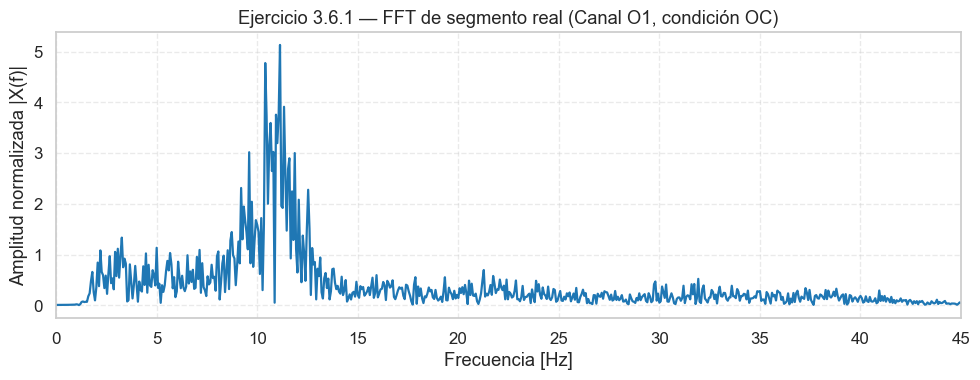

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# --- Seleccionar segmento ---
seg = OC     # Cambiar a OA para comparar
N   = len(seg)

# --- Transformada rápida de Fourier ---
X  = np.fft.fft(seg)
fx = np.fft.fftfreq(N, d=1/fs)

# --- Calcular semiespectro (amplitud normalizada) ---
half = N // 2
mag = 2 * np.abs(X[:half]) / N
freqs_pos = fx[:half]

# --- Visualización ---
plt.figure(figsize=(10,4))
plt.plot(freqs_pos, mag, color="tab:blue", lw=1.6)
plt.xlim(0, 45)
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud normalizada |X(f)|")
plt.title("Ejercicio 3.6.1 — FFT de segmento real (Canal O1, condición OC)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


**Preguntas para reflexión.**
- ¿En qué frecuencia se ubica el máximo principal?  
- ¿Cambia la amplitud del pico si se sustituye `OC` por `OA`?  
- ¿Qué relación guarda el máximo con la banda α (8–13 Hz)?


### 3.6.2 — Comparación entre FFT directa y método de Welch (datos reales)

**Objetivo.** Contrastar la variabilidad del periodograma simple (FFT directa) con la estimación estabilizada de Welch.

**Datos.** Se usa **OC** por defecto (mayor α).  

**Instrucciones.**
1. Grafique la FFT directa (periodograma simple).  
2. Sobre la misma figura, grafique la PSD por Welch (mismos parámetros que en 3.2).  
3. Cambie `nperseg` para observar el compromiso entre resolución y suavizado.


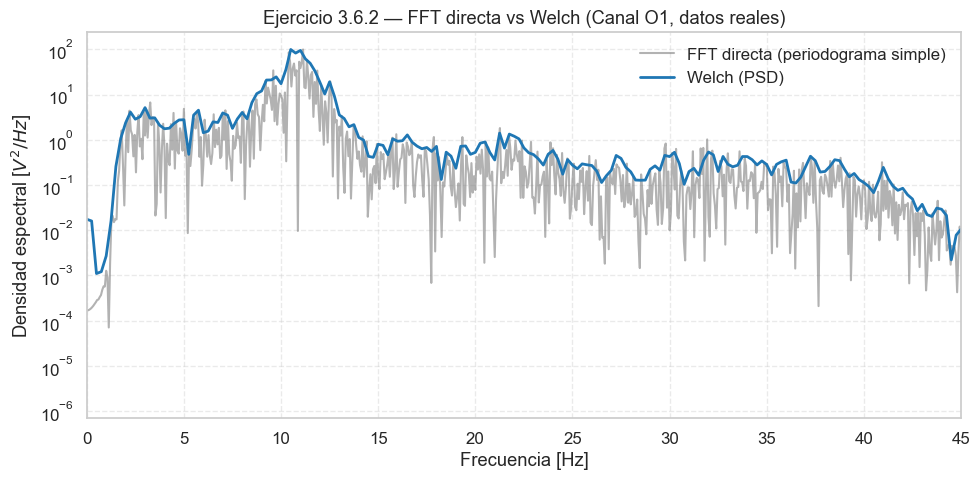

In [13]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

# --- Seleccionar segmento ---
seg = OC   # Cambiar a OA para comparar
N   = len(seg)

# --- FFT directa (periodograma simple) ---
X   = np.fft.fft(seg)
fx  = np.fft.fftfreq(N, d=1/fs)
P_fft = (np.abs(X[:N//2])**2) / (fs * N)   # Escalado comparable con Welch

# --- Método de Welch (parámetros de la nota metodológica) ---
nperseg = 512
noverlap = nperseg // 2
ventana  = "hamming"
fw, Pw = signal.welch(seg, fs=fs, window=ventana,
                      nperseg=nperseg, noverlap=noverlap,
                      scaling="density")

# --- Visualización ---
plt.figure(figsize=(10,5))
plt.semilogy(fx[:N//2], P_fft, color="tab:gray", alpha=0.6, label="FFT directa (periodograma simple)")
plt.semilogy(fw, Pw, color="tab:blue", lw=2, label="Welch (PSD)")

plt.xlim(0, 45)
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Densidad espectral [$V^2/Hz$]")
plt.title("Ejercicio 3.6.2 — FFT directa vs Welch (Canal O1, datos reales)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()



**Preguntas para reflexión.**
- ¿Cómo cambia la suavidad del espectro con Welch respecto a la FFT directa?  
- ¿El pico en α (~10 Hz) se preserva en ambos métodos?  
- ¿Qué ocurre al aumentar/disminuir `nperseg`? Relacione con la resolución en frecuencia.


### 3.6.3 — Integración de la PSD por banda (Simpson vs trapezoidal) con datos reales

**Objetivo.** Cuantificar la potencia espectral en la banda α (8–13 Hz) usando **Simpson** y compararla con **trapezoidal**.

**Datos.** Se emplean las PSD ya calculadas en 3.2:  
- `f_a, P_a` (OA) y `f_c, P_c` (OC), en unidades $V^2/Hz$.

**Instrucciones.**
1. Integre en α usando `scipy.integrate.simpson`.  
2. Repita con `scipy.integrate.trapezoid`.  
3. Compare OA vs OC y comente la magnitud de la diferencia.


In [14]:
from scipy.integrate import simpson, trapezoid
import numpy as np

# --- Definir límites de la banda α ---
fmin, fmax = 8.0, 13.0

# --- Índices de la banda para OA y OC ---
idx_OA = (f_OA >= fmin) & (f_OA <= fmax)
idx_OC = (f_OC >= fmin) & (f_OC <= fmax)

# --- Integración con Simpson y trapecios (OA) ---
P_alpha_OA_sim  = simpson(P_OA[idx_OA], f_OA[idx_OA])
P_alpha_OA_trap = trapezoid(P_OA[idx_OA], f_OA[idx_OA])

# --- Integración con Simpson y trapecios (OC) ---
P_alpha_OC_sim  = simpson(P_OC[idx_OC], f_OC[idx_OC])
P_alpha_OC_trap = trapezoid(P_OC[idx_OC], f_OC[idx_OC])

# --- Resultados numéricos ---
print("Banda α (8–13 Hz) — Potencia integrada [V²]")
print(f"{'':<4}OA | Simpson: {P_alpha_OA_sim:>10.3e}   | Trapezoidal: {P_alpha_OA_trap:>10.3e}")
print(f"{'':<4}OC | Simpson: {P_alpha_OC_sim:>10.3e}   | Trapezoidal: {P_alpha_OC_trap:>10.3e}")

# --- Diferencia relativa (OC vs OA, método de Simpson) ---
if P_alpha_OC_sim != 0:
    diff_rel = 100.0 * (P_alpha_OC_sim - P_alpha_OA_sim) / P_alpha_OC_sim
    print(f"\nDiferencia relativa (OC vs OA, Simpson): {diff_rel:.1f}%")
else:
    print("\nAdvertencia: potencia α en OC es cero o no definida.")


Banda α (8–13 Hz) — Potencia integrada [V²]
    OA | Simpson:  1.705e+01   | Trapezoidal:  1.696e+01
    OC | Simpson:  1.535e+02   | Trapezoidal:  1.578e+02

Diferencia relativa (OC vs OA, Simpson): 88.9%


**Preguntas para reflexión.**
- ¿Cuál método (Simpson o trapezoidal) entrega mayor potencia integrada en α? ¿Por qué?  
- ¿La diferencia OA vs OC coincide con la expectativa fisiológica del bloqueo α?  
- ¿Cómo afectaría este cálculo si cambiara la banda a θ (4–8 Hz) o β (13–30 Hz)?


### 3.6.4 — Modificar los límites de la banda α y observar el desplazamiento del pico

**Objetivo.** Analizar cómo la elección de los límites de la banda α (8–13 Hz) afecta la frecuencia y potencia máxima de la señal EEG real.

**Datos.** Se usa la PSD de **ojos cerrados (OC)**, por su mayor estabilidad en el ritmo α.

**Instrucciones.**
1. Visualice la PSD original en el rango 5–20 Hz.  
2. Modifique los límites de la banda α (por ejemplo, 7–12 Hz o 9–14 Hz).  
3. Observe cómo cambian la frecuencia y la potencia del pico.  
4. Relacione las variaciones con la noción de *variabilidad interindividual* del ritmo α (Nunez & Srinivasan, 2006).


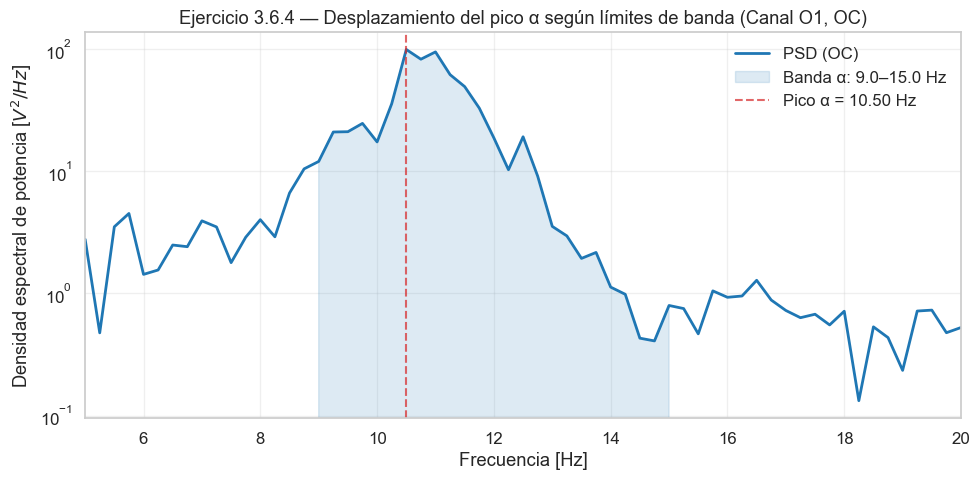

Banda α: 9.0–15.0 Hz
Frecuencia pico α: 10.50 Hz
Potencia integrada α: 1.498e+02 V²


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson

# --- Usar PSD de ojos cerrados (más estable) ---
f = f_OC
P = P_OC

# --- Rango de visualización general (zoom 5–20 Hz) ---
fmin_zoom, fmax_zoom = 5.0, 20.0
idx_zoom = (f >= fmin_zoom) & (f <= fmax_zoom)

# ===========================================================
# Definir límites de la banda α (puede modificarse libremente)
# ===========================================================
fmin_alpha, fmax_alpha = 9.0, 15.0   # ← Cambia a 7–12 o 9–14 para experimentar

# --- Selección de la banda actual ---
idx_alpha = (f >= fmin_alpha) & (f <= fmax_alpha)

# --- Calcular frecuencia y potencia máxima dentro de la banda ---
f_alpha_peak = f[idx_alpha][np.argmax(P[idx_alpha])]
P_alpha_peak = np.max(P[idx_alpha])

# --- Calcular potencia integrada de la banda actual ---
P_alpha_band = simpson(P[idx_alpha], f[idx_alpha])

# --- Visualización ---
plt.figure(figsize=(10,5))
plt.semilogy(f[idx_zoom], P[idx_zoom], color="tab:blue", lw=2, label="PSD (OC)")
plt.fill_between(f[idx_alpha], P[idx_alpha], color="tab:blue", alpha=0.15,
                 label=f"Banda α: {fmin_alpha:.1f}–{fmax_alpha:.1f} Hz")
plt.axvline(f_alpha_peak, color="tab:red", linestyle="--", alpha=0.7,
            label=f"Pico α = {f_alpha_peak:.2f} Hz")

plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Densidad espectral de potencia [$V^2/Hz$]")
plt.title("Ejercicio 3.6.4 — Desplazamiento del pico α según límites de banda (Canal O1, OC)")
plt.xlim(fmin_zoom, fmax_zoom)
plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# --- Mostrar valores numéricos ---
print(f"Banda α: {fmin_alpha:.1f}–{fmax_alpha:.1f} Hz")
print(f"Frecuencia pico α: {f_alpha_peak:.2f} Hz")
print(f"Potencia integrada α: {P_alpha_band:.3e} V²")


**Preguntas para reflexión.**
- ¿Qué ocurre con el valor del pico α al modificar los límites de la banda?  
- ¿Cómo cambia la potencia integrada al ampliar o estrechar el rango?  
- ¿Por qué no existe un único rango “correcto” para la banda α entre individuos o sesiones?  
- ¿Qué implicaciones tiene esto para la comparación estadística de potencias entre sujetos?


### 3.6.5 — Efecto del tipo de ventana en la estimación de la PSD

**Objetivo.** Explorar cómo la elección de la ventana de análisis (Hamming, Hann, Blackman) influye en la forma y amplitud de la PSD.

**Datos.** Segmento **OC (120–135 s)** del canal O1.  
La señal se procesa tres veces con distintas ventanas manteniendo los demás parámetros constantes.

**Instrucciones.**
1. Calcule la PSD usando tres tipos de ventana.  
2. Grafique las tres curvas sobre la misma figura.  
3. Observe los cambios en el ancho del pico α y en el nivel de ruido espectral.


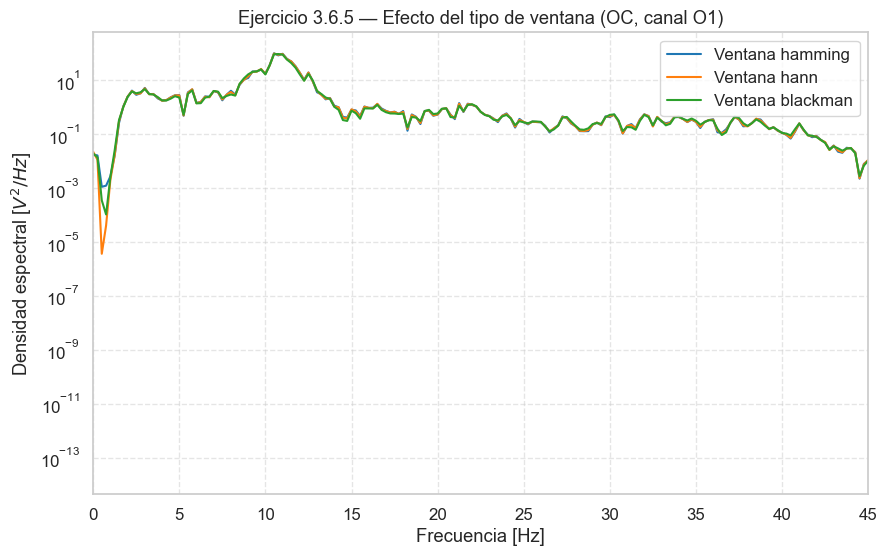

In [16]:
# 3.6.5 — Efecto del tipo de ventana sobre la PSD (datos reales)

ventanas = ["hamming", "hann", "blackman"]
colores  = ["tab:blue", "tab:orange", "tab:green"]

plt.figure(figsize=(10,6))

for vent, col in zip(ventanas, colores):
    f_temp, P_temp = signal.welch(OC, fs=128, window=vent,
                                  nperseg=512, noverlap=256, scaling="density")
    plt.semilogy(f_temp, P_temp, color=col, label=f"Ventana {vent}")

plt.xlim(0, 45)
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Densidad espectral [$V^2/Hz$]")
plt.title("Ejercicio 3.6.5 — Efecto del tipo de ventana (OC, canal O1)")
plt.legend()
plt.grid(True, ls="--", alpha=0.5)
plt.show()


**Preguntas para reflexión.**
- ¿Cuál ventana produce el espectro más estrecho en torno al pico α?  
- ¿Qué ventana genera el nivel más bajo de ruido espectral?  
- ¿Por qué una ventana que suaviza más puede disminuir la amplitud máxima?  
- ¿Cómo se equilibra el compromiso entre resolución y estabilidad en el análisis de EEG?


## 3.7 Reflexión final

El análisis espectral desarrollado en este notebook permitió pasar del dominio temporal al dominio frecuencial  
para caracterizar la actividad eléctrica cerebral registrada en el canal occipital O1.  
A través del método de Welch y la integración numérica mediante Simpson,  
se obtuvo una descripción cuantitativa y reproducible de la distribución de potencia del EEG  
en las principales bandas fisiológicas.

Los resultados mostraron tres hallazgos consistentes:

1. **Presencia del ritmo α (8–13 Hz) en condición de ojos cerrados (OC).**  
   La PSD evidenció un pico claro alrededor de 10 Hz,  
   cuya potencia aumentó significativamente con respecto a la condición de ojos abiertos (OA).  
   Este comportamiento corresponde al fenómeno de **bloqueo alfa**  
   descrito en la literatura clásica (Pfurtscheller & Lopes da Silva, 1999).

2. **Redistribución de potencia relativa entre bandas.**  
   El histograma espectral mostró que, al abrir los ojos,  
   la energía en α disminuye mientras se incrementa levemente la contribución de β y γ,  
   coherente con la activación sensorial y cognitiva asociada al procesamiento visual  
   (Nunez & Srinivasan, 2006).

3. **Coherencia entre métodos numéricos.**  
   La integración de la PSD con Simpson demostró ser estable y precisa,  
   confirmando que las diferencias observadas no dependen del método de estimación,  
   sino de cambios fisiológicos reales en la actividad cortical.

Desde una perspectiva biomatemática, estos resultados ilustran cómo un **modelo matemático no impone la realidad fisiológica**,  
sino que **proporciona un marco para describirla y cuantificarla**.  
La señal EEG no se adapta perfectamente a los supuestos de estacionariedad y linealidad que requiere el análisis espectral,  
pero el uso de intervalos breves y técnicas de promediado —como el método de Welch—  
permite aproximar la dinámica neuronal a un sistema cuasiestacionario,  
suficiente para comparar condiciones experimentales.

Entre las **limitaciones del enfoque**, destacan:

- La pérdida de información temporal al asumir estacionariedad en ventanas de 4 s.  
- La imposibilidad de distinguir transiciones rápidas o transitorios corticales.  
- La dependencia de los resultados respecto a la elección de parámetros (ventana, solape, longitud del segmento).

Aun con estas limitaciones, el análisis espectral conserva gran valor pedagógico y fisiológico:  
permite vincular la descripción matemática del espectro con los mecanismos neuronales de sincronización y desincronización.  
De esta manera, el Notebook 3 establece una **base cuantitativa sólida** para el estudio del EEG  
y un **puente conceptual** hacia los métodos de análisis tiempo–frecuencia que se abordarán en el Notebook 4.


## 3.8 Bibliografía

Burden, R. L., & Faires, J. D. (2010). *Análisis numérico* (9.ª ed.). Cengage Learning.

Bronzino, J. D., & Peterson, D. R. (Eds.). (2020). *The biomedical engineering handbook* (5th ed.). CRC Press.

Cohen, M. X. (2014). *Analyzing neural time series data: Theory and practice*. MIT Press.

Hsu, W. Y., Lin, C. L., & Ju, M. S. (2021). Influence of Welch method parameters on EEG signal analysis. *Sensors*, 21(17), 5740. https://doi.org/10.3390/s21175740

Nunez, P. L., & Srinivasan, R. (2006). *Electric fields of the brain: The neurophysics of EEG* (2nd ed.). Oxford University Press.

Oppenheim, A. V., & Schafer, R. W. (2010). *Discrete-time signal processing* (3rd ed.). Pearson.

Papoulis, A. (1984). *Signal analysis*. McGraw-Hill.

Pfurtscheller, G., & Lopes da Silva, F. H. (1999). Event-related EEG/MEG synchronization and desynchronization: Basic principles. *Clinical Neurophysiology*, 110(11), 1842–1857. https://doi.org/10.1016/S1388-2457(99)00141-8

Proakis, J. G., & Manolakis, D. G. (2006). *Digital signal processing: Principles, algorithms, and applications* (4th ed.). Pearson Prentice Hall.

Smith, S. W. (1997). *The scientist and engineer’s guide to digital signal processing*. California Technical Publishing.

Virtanen, P., Gommers, R., Oliphant, T. E., Haberland, M., Reddy, T., Cournapeau, D., ... & van Mulbregt, P. (2020). SciPy 1.0: Fundamental algorithms for scientific computing in Python. *Nature Methods*, 17, 261–272. https://doi.org/10.1038/s41592-019-0686-2

Welch, P. D. (1967). The use of fast Fourier transform for the estimation of power spectra: A method based on time averaging over short, modified periodograms. *IEEE Transactions on Audio and Electroacoustics*, 15(2), 70–73. https://doi.org/10.1109/TAU.1967.1161901
